In [1]:
# Install package containing prebuilt image models
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-1813_06c
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-1813_06c
  Resolved https://github.com/tensorflow/examples.git to commit 0bbf4fe43fbf41b7174b9ce4a64d69bd33aadd21
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1689703202.67065300351684276117070052891639684042406419745-py3-none-any.whl size=301556 sha256=7457161e79c7d4342544d23135795ebd32b758e1d525354c87bbb8b104ed2070
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zjwkppb/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import os
import tensorflow as tf
from tqdm import tqdm
import cv2

In [3]:
print(tf.__version__)

2.12.0


In [4]:
import numpy as np

In [5]:
# need to mount google drive to fetch dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_PATH_X = '/content/drive/MyDrive/Colab Notebooks/seep_detection/train_images_256'
DATA_PATH_Y = '/content/drive/MyDrive/Colab Notebooks/seep_detection/train_masks_256'

image_files = []
mask_files = []

# Fetching Input image data path into list
for root, dirs, files in os.walk(DATA_PATH_X):
    for file in tqdm(files):
        img_path = os.path.join(DATA_PATH_X, file)
        mask_path = os.path.join(DATA_PATH_Y, file)
        image_files.append(img_path)
        mask_files.append(mask_path)

100%|██████████| 790/790 [00:00<00:00, 164164.69it/s]


In [7]:
from sklearn.model_selection import train_test_split
#Shuffling and splitting total data(1000 image-mask pair) into Train and Test data with split of (90%, 10%)
train_X, test_X, train_Y, test_Y = train_test_split(image_files, mask_files, test_size=0.1, random_state=33)

In [8]:
len(train_X)

711

In [9]:
# need to use openCV for readinf .tif images and making it part of
# tf.data.Dataset pipeline
def parse_with_opencv(image_path):
  image = cv2.imread(image_path.decode('UTF-8'))
  image = cv2.resize(image, (128, 128))
  return image

In [10]:
def parse_mask_with_opencv(image_path):
  image = cv2.imread(image_path.decode('UTF-8'))
  image = cv2.resize(image, (128, 128))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #image = tf.reshape(image, shape=[256,256,1])
  image = np.expand_dims(image, -1)
  return image

In [11]:
image_files[0], mask_files[0]

('/content/drive/MyDrive/Colab Notebooks/seep_detection/train_images_256/041869.000045.tif',
 '/content/drive/MyDrive/Colab Notebooks/seep_detection/train_masks_256/041869.000045.tif')

In [ ]:
# common error when decoding file_path as string from string Tensor, in pipeline (not outside):
# following code did not worked:
# image = tifffile.imread(file_path)
# error happens is pathname is not string but tensor
# following method do not worked to resolve above
# 1. tf.strings.decode(eager_tensor[0], 'utf-8')
#-> AttributeError: module 'tensorflow._api.v2.strings' has no attribute 'decode'
# 2. img_ptth = img_tensor[0].numpy().decode('utf-8')
# -> AttributeError: 'Tensor' object has no attribute 'numpy'

In [12]:
# map is required as image needs to read and decoded in proper format. (only for local dataset)
train_image_ds = tf.data.Dataset.from_tensor_slices((train_X)).map(
    lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=tf.uint8)
)

train_mask_ds = tf.data.Dataset.from_tensor_slices((train_Y)).map(
    lambda x: tf.numpy_function(parse_mask_with_opencv, [x], Tout=tf.uint8)
)
train_dataset = tf.data.Dataset.zip((train_image_ds, train_mask_ds))

In [13]:
test_image_ds = tf.data.Dataset.from_tensor_slices((test_X)).map(
    lambda x: tf.numpy_function(parse_with_opencv, [x], Tout=tf.uint8)
)

test_mask_ds = tf.data.Dataset.from_tensor_slices((test_Y)).map(
    lambda x: tf.numpy_function(parse_mask_with_opencv, [x], Tout=tf.uint8)
)
test_dataset = tf.data.Dataset.zip((test_image_ds, test_mask_ds))

In [14]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

In [15]:
@tf.function
def load_image_train(image_tensor, mask_tensor):

  # Preprocessing layer
  #input_image = tf.image.resize(image_tensor, (256, 256))
  #input_mask = tf.image.resize(mask_tensor, (256, 256))

  # Image Augmentation layers : random flip
  # if tf.random.uniform(()) > 0.5:
  #   input_image = tf.image.flip_left_right(input_image)
  #   input_mask = tf.image.flip_left_right(input_mask)
  #   input_image = tf.image.flip_up_down(input_image)
  #   input_mask = tf.image.flip_up_down(input_mask)

  # Image augmentation layer : random crop
  image = tf.reshape(image_tensor, shape=[128,128,3])
  mask = tf.reshape(mask_tensor, shape=[128,128,1])

  input_image, input_mask = normalize(image_tensor, mask_tensor)

  return input_image, input_mask

In [16]:
# No augmentation is not needed for test dataset

def load_image_test(image_tensor, mask_tensor):
  #input_image = tf.image.resize(datapoint['image'], (128, 128))
  #input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  image = tf.reshape(image_tensor, shape=[128,128,3])
  mask = tf.reshape(mask_tensor, shape=[128,128,1])

  input_image, input_mask = normalize(image_tensor, mask_tensor)

  return input_image, input_mask

In [17]:
TRAIN_LEN = 711
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LEN // BATCH_SIZE

In [18]:
# Visualize the datset
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [19]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
for img, msk in train.take(4):
  sample_img, sample_msk = img, msk
  break;

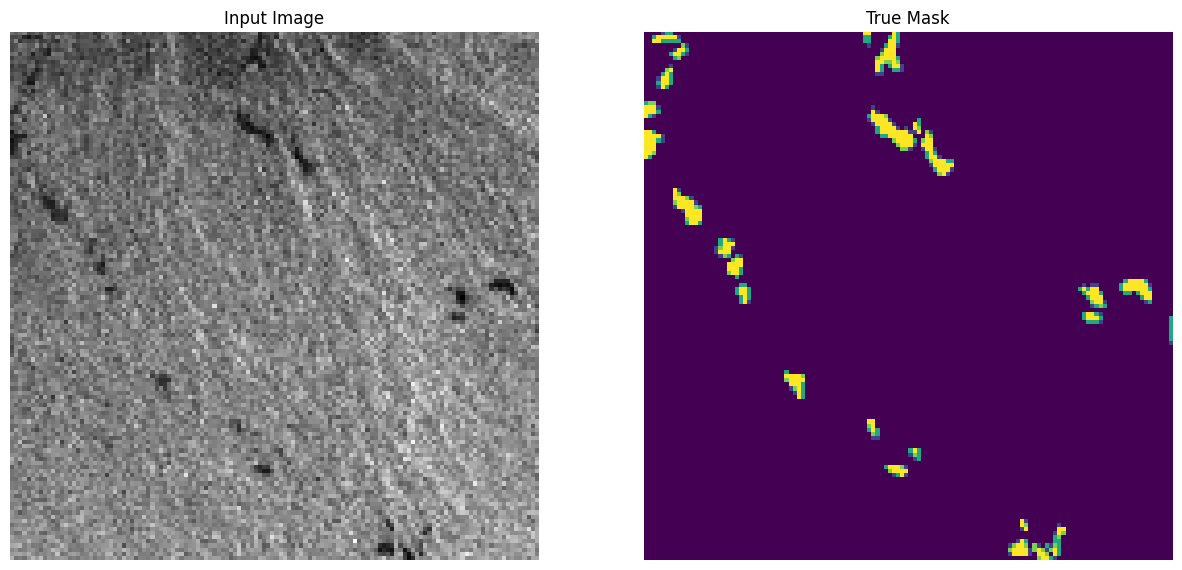

In [21]:
display([sample_img, sample_msk])

In [22]:
sample_msk, np.unique(sample_msk.numpy())

(<tf.Tensor: shape=(128, 128, 1), dtype=uint8, numpy=
 array([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [3],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [5],
         ...,
         [0],
         [0],
         [0]],
 
        ...,
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],
 
        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=uint8)>,
 array([0, 1, 3, 4, 5], dtype=uint8))

In [1]:
# Note: shape needs to set again if
# .map(lambda x: tf.numpy_function(parse_mask_with_opencv, [x], Tout=tf.uint8) is
# used in the pipeline.
# common error : ValueError: as_list() is not defined on an unknown TensorShape.
# for more detials:
# https://discuss.tensorflow.org/t/valueerror-as-list-is-not-defined-on-an-unknown-tensorshape/5577
def _fixup_shape(images, masks):
    images.set_shape([128, 128, 3])
    masks.set_shape([128, 128, 1]) # I have 19 classes
    # weights.set_shape([None])
    return images, masks

In [24]:
train_ds = (
    train_dataset
    .map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(_fixup_shape)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    )

test_ds = (
    test_dataset
    .map(load_image_test)
    .map(_fixup_shape)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
)

In [31]:
arr = []
for img, msk in train.take(20):
  sample_img, sample_msk = img, msk
  arr.append(np.unique(sample_msk.numpy()))

In [32]:
arr

[array([0, 1, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4], dtype=uint8),
 array([0, 1, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 4, 5, 7], dtype=uint8),
 array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3, 5, 6], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 3, 4, 5], dtype=uint8),
 array([0, 2, 3, 5, 6], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 2, 3, 5, 6], dtype=uint8),
 array([0, 1, 2], dtype=uint8),
 array([0, 1, 2, 4, 5, 7], dtype=uint8),
 array([0, 1, 2, 3, 5, 6], dtype=uint8),
 array([0, 1], dtype=uint8)]

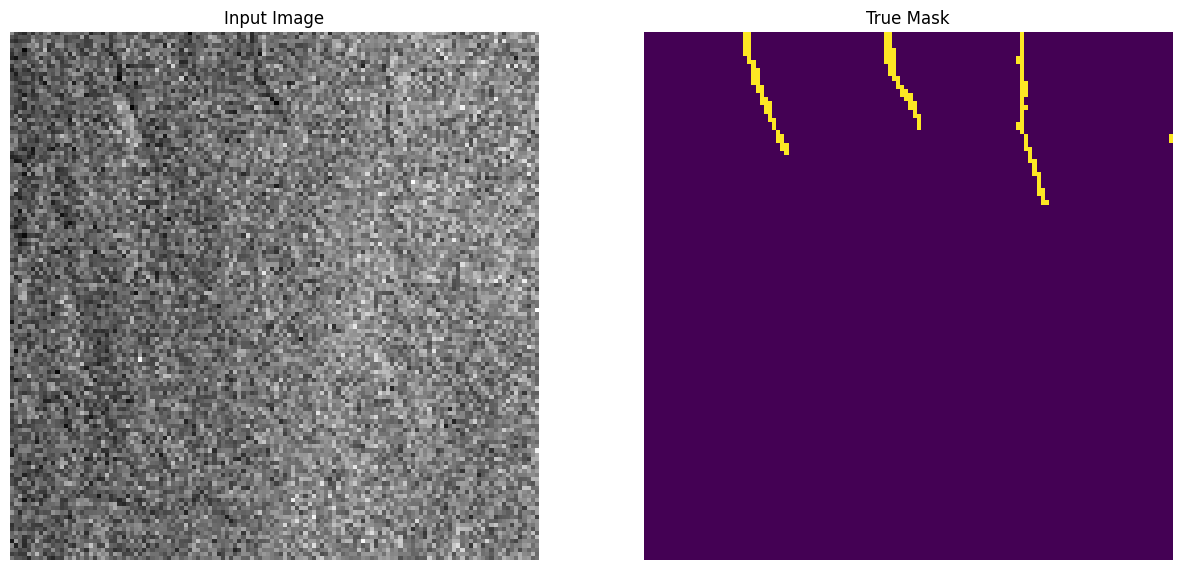

In [33]:
display([sample_img, sample_msk])

In [34]:
sample_img.shape.as_list(), sample_msk.shape.as_list()

([128, 128, 3], [128, 128, 1])

In [35]:
# Setting number of output channels : number of classes = 8 : [0, 1, 2, 3, 4, 5, 6, 7]
OUTPUT_CHANNELS = 8

In [36]:
from tensorflow_examples.models.pix2pix import pix2pix


In [37]:
# Input size is very important to mention as weights according to the input size will be downloaded
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

9406464/9406464 [==============================] - 1s 0us/step


In [38]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model also called Encoder Layers.
encoding_layer_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

encoding_layer_stack.trainable = False

In [39]:
decoding_layer_stack = [
    pix2pix.upsample(512, 3),   # 4x4 -> 8x8
    pix2pix.upsample(256, 3),   # 8x8 -> 16x16
    pix2pix.upsample(128, 3),   # 16x16 -> 32x32
    pix2pix.upsample(64, 3),    # 32x32 -> 64x64
]

In [40]:
def unet_segmentation_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Encoder Layer: Downsampling through the model
  encoding_skips = encoding_layer_stack(inputs)
  x = encoding_skips[-1]
  encoding_skips = reversed(encoding_skips[:-1])

  # Decoder: Upsampling and establishing the skip connections
  for up, encoding_skip in zip(decoding_layer_stack, encoding_skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, encoding_skip])

  # Output Layer: This is the last layer of the model
  last_decoding_layer = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')                # 64x64 -> 128x128

  output = last_decoding_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=output)

In [43]:
# Creating prediction display function
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=90):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_img, sample_msk,
             create_mask(model.predict(sample_img[tf.newaxis, ...]))])

In [44]:
# Display output

from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [46]:
model = unet_segmentation_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [ ]:
# Setting parameters and start model training
EPOCHS = 10
VAL_SUBSPLITS = 2
VALIDATION_STEPS = 79//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()]
                          )

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plotting Loss per epochs for model learning
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Make predictions from test dataset
show_predictions(test_ds, 3)